# Randomized Controlled Trials Identification

This notebook was developed by **I Made Akira Ivandio Agusta (15406525)**, Coventry University.

This notebook introduces an enhanced **hierarchical model** for **RCT classification** that combines **PubMedBERT** with convolutional neural networks, focal loss, and data augmentation.

The experiments were conducted on the **Bat4RCT** dataset.

## Setup and Utilities

This section imports necessary libraries, mounts Google Drive, sets up required directories, and establishes a random seed for reproducibility to ensure consistent results across runs.

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns
import torch
import transformers
from google.colab import drive
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics import accuracy_score, auc, average_precision_score, confusion_matrix, f1_score, precision_recall_curve, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_scheduler

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Mount Google Drive
drive.flush_and_unmount()
drive.mount('/content/drive')

# Define the base directory
BASE_DIR = '/content/drive/MyDrive/rct/'
DATA_DIR = os.path.join(BASE_DIR, 'data/')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures/')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
# Set seed for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(42)

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Exploration

This section loads the RCT dataset from a TXT file, displays basic statistics, and visualizes the class distribution to understand the imbalance between RCT and non-RCT papers.

In [ ]:
# Function to load data
def load_data(file_path):
    # The data format is: PMID, pubtype, year, title, abstract
    df = pd.read_csv(
        file_path,
        sep='\t',
        header=None,
        names=['pmid', 'is_rct', 'year', 'title', 'abstract'],
        encoding='utf-8',
        quoting=3,
        on_bad_lines='warn'
    )

    # Print dataset statistics
    print(f"\nFull dataset size: {len(df)}")
    print(f"\nMissing values in the dataset:\n{df.isnull().sum()}")

    return df

In [ ]:
# Define the file path
file_path = os.path.join(DATA_DIR, 'rct_data.txt')

# Verify the file exists
if os.path.exists(file_path):
    print(f"File found at: {file_path}")

    # Load data
    df = load_data(file_path)
else:
    print(f"Error: File not found at {file_path}")

File found at: /content/drive/MyDrive/rct/data/rct_data.txt

Full dataset size: 500105

Missing values in the dataset:
pmid        0
is_rct      0
year        0
title       0
abstract    0
dtype: int64


In [ ]:
# View loaded DataFrame
df

,pmid,is_rct,year,title,abstract
0,18439781,0,2011,Two patients subdued with a TASER® device: cas...,"In the United States, an increasing number of ..."
1,18468833,0,2011,A case of Takayasu arteritis causing subclavia...,The American Heart Association website defines...
2,18481181,0,2012,Pathophysiology of hypopituitarism in the sett...,The complex pathophysiology of traumatic brain...
3,18728056,1,2011,"The cardiovascular risk factor, soluble CD40 l...",[BACKGROUND] Soluble CD40 ligand (sCD40L) is a...
4,18790590,0,2011,Horner syndrome due to carotid dissection.,[BACKGROUND] Internal carotid artery dissectio...
...,...,...,...,...,...
500100,34877128,0,2018,Transient Thermal Response of a Guarded-Hot-Pl...,A mathematical model is presented for a new-ge...
500101,34877131,0,2018,Industrial Wireless End-to-End Measurements an...,Industrial wireless is a potential networking ...
500102,34877132,0,2018,Realizations of the Triple Point of Sulfur Hex...,The Minamata Convention on Mercury has created...
500103,34877139,0,2018,How to Define the Units of the Revised SI Star...,As part of a revision to the International Sys...


In [ ]:
# Function to visualize RCT distribution
def visualize_rct_distribution(df):
    # Get RCT distribution
    rct_distribution = df['is_rct'].value_counts()
    print(f"RCT distribution: {rct_distribution}")

    # Visualize RCT distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=rct_distribution.index, y=rct_distribution.values)
    plt.title('RCT Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')

    # Save figure
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'rct_distribution.png'))
    plt.show()
    plt.close()

RCT distribution: is_rct
0    400096
1    100009
Name: count, dtype: int64


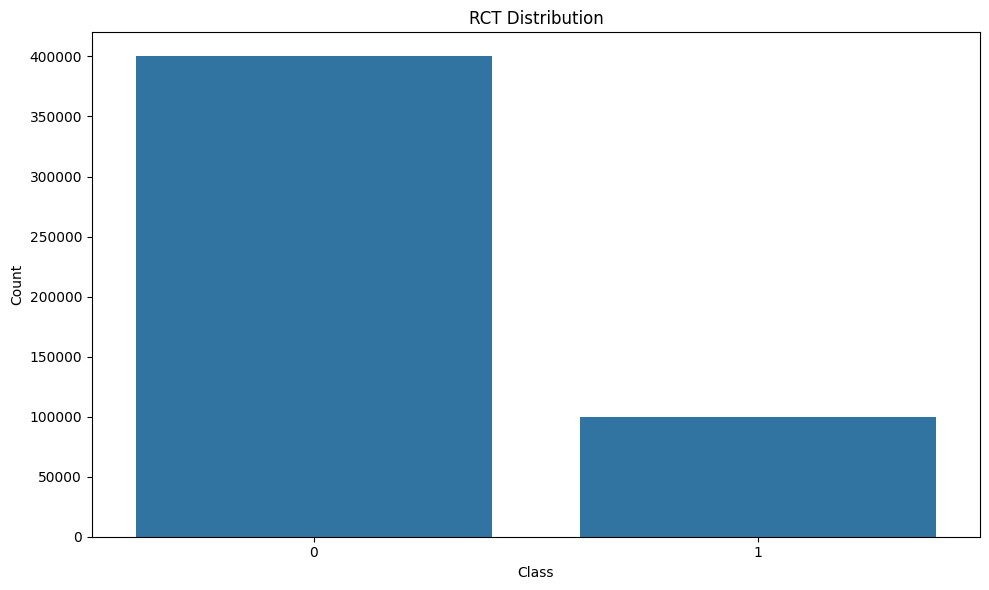

In [ ]:
# Visualize RCT distribution
visualize_rct_distribution(df)

## Data Preprocessing

This section combines title and abstract text, extracts potential PICO elements (Population, Intervention, Comparison, Outcome) using regular expressions, and creates a custom dataset class with data augmentation functionality.

In [ ]:
def preprocess_text(df):
    # Create a copy to avoid modifying the original
    processed_df = df.copy()

    # Combine title and abstract
    processed_df['text'] = processed_df['title'] + " [SEP] " + processed_df['abstract']

    # Extract potential PICO elements
    # Population markers
    processed_df['has_population'] = processed_df['text'].apply(
        lambda x: 1 if re.search(r'\b(patient|subject|participant|people|individual|adult|men|women)\b',
                                x.lower()) else 0)

    # Intervention markers
    processed_df['has_intervention'] = processed_df['text'].apply(
        lambda x: 1 if re.search(r'\b(treatment|therapy|intervention|administered|received|given|dose)\b',
                                x.lower()) else 0)

    # Comparison markers
    processed_df['has_comparison'] = processed_df['text'].apply(
        lambda x: 1 if re.search(r'\b(vs\.|versus|compared|comparison|control group|placebo)\b',
                                x.lower()) else 0)

    # Outcome markers
    processed_df['has_outcome'] = processed_df['text'].apply(
        lambda x: 1 if re.search(r'\b(outcome|result|effectiveness|efficacy|mortality|survival|improved)\b',
                               x.lower()) else 0)

    # Identify method section (simplified)
    processed_df['has_method_section'] = processed_df['abstract'].apply(
        lambda x: 1 if re.search(r'\b(method|methodology|procedure|design|approach)\b',
                               x.lower()) else 0)

    # Flag for randomization terms
    processed_df['has_randomization'] = processed_df['text'].apply(
        lambda x: 1 if re.search(r'\b(random|randomized|randomised|randomly assigned|allocation)\b',
                                x.lower()) else 0)

    return processed_df

In [ ]:
# Custom dataset class
class RCTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Remove the batch dimension
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}

        # Add the label
        encoding['labels'] = torch.tensor(label, dtype=torch.long)

        return encoding

In [ ]:
def synonym_replacement(text, n=1):
    words = text.split()
    if len(words) <= n:
        return text

    # Medical term replacements
    replacements = {
        'patients': ['subjects', 'participants', 'individuals'],
        'study': ['trial', 'investigation', 'analysis'],
        'treatment': ['therapy', 'intervention', 'regimen'],
        'medication': ['drug', 'pharmaceutical', 'agent'],
        'effect': ['impact', 'influence', 'outcome'],
        'disease': ['disorder', 'condition', 'illness']
    }

    # Select random words to replace
    replace_indices = random.sample(range(len(words)), min(n, len(words)))

    for idx in replace_indices:
        word = words[idx].lower()
        if word in replacements:
            words[idx] = random.choice(replacements[word])

    return ' '.join(words)

In [ ]:
def create_augmented_data(df, proportion=0.3):
    # Select a subset of rows to augment
    augment_count = int(len(df) * proportion)
    augment_indices = random.sample(range(len(df)), augment_count)

    augmented_texts = []
    augmented_labels = []

    for idx in augment_indices:
        text = df.iloc[idx]['text']
        label = df.iloc[idx]['is_rct']

        # Apply synonym replacement
        augmented_text = synonym_replacement(text, n=3)

        augmented_texts.append(augmented_text)
        augmented_labels.append(label)

    return augmented_texts, augmented_labels

In [ ]:
def prepare_data(df, model_name, augment=True, sample_size=None):
    # Sample if requested
    if sample_size is not None and sample_size < len(df):
        # Stratified sampling to maintain class distribution
        rct_df = df[df['is_rct'] == 1]
        non_rct_df = df[df['is_rct'] == 0]

        # Calculate proportional sample sizes
        rct_ratio = len(rct_df) / len(df)
        rct_sample_size = int(sample_size * rct_ratio)
        non_rct_sample_size = sample_size - rct_sample_size

        # Sample from each class
        rct_sample = rct_df.sample(min(rct_sample_size, len(rct_df)), random_state=42)
        non_rct_sample = non_rct_df.sample(min(non_rct_sample_size, len(non_rct_df)), random_state=42)

        # Combine samples
        sampled_df = pd.concat([rct_sample, non_rct_sample]).sample(frac=1, random_state=42)

        print(f"Sampled dataset size: {len(sampled_df)}")
        print(f"Sampled RCT distribution: {sampled_df['is_rct'].value_counts()}")

        df = sampled_df

    # Preprocess the data
    processed_df = preprocess_text(df)

    # Split into train, validation, and test sets
    train_df, temp_df = train_test_split(processed_df, test_size=0.2, stratify=processed_df['is_rct'], random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['is_rct'], random_state=42)

    print(f"Train set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")
    print(f"Test set size: {len(test_df)}")

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Prepare datasets
    train_texts = train_df['text'].tolist()
    train_labels = train_df['is_rct'].tolist()

    # Data augmentation for the training set
    if augment:
        aug_texts, aug_labels = create_augmented_data(train_df)
        train_texts.extend(aug_texts)
        train_labels.extend(aug_labels)
        print(f"Added {len(aug_texts)} augmented examples. New train size: {len(train_texts)}")

    val_texts = val_df['text'].tolist()
    val_labels = val_df['is_rct'].tolist()

    test_texts = test_df['text'].tolist()
    test_labels = test_df['is_rct'].tolist()

    # Create datasets
    train_dataset = RCTDataset(train_texts, train_labels, tokenizer)
    val_dataset = RCTDataset(val_texts, val_labels, tokenizer)
    test_dataset = RCTDataset(test_texts, test_labels, tokenizer)

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=32)
    test_dataloader = DataLoader(test_dataset, batch_size=32)

    return train_dataloader, val_dataloader, test_dataloader, train_df, val_df, test_df

## Model Architecture

This section implements a hierarchical PubMedBERT model with CNN layer integration to capture local patterns in the text, enhancing the model's ability to identify RCT-specific language structures.

In [ ]:
class HierarchicalPubMedBERT(torch.nn.Module):
    def __init__(self, model_name, num_labels=2):
        super(HierarchicalPubMedBERT, self).__init__()

        # Load the pretrained model
        self.bert = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels
        )

        # Get the hidden size from the model config
        hidden_size = self.bert.config.hidden_size

        # CNN layer for capturing local patterns
        self.conv = torch.nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)

        # Final classification layer
        self.classifier = torch.nn.Linear(hidden_size, num_labels)

        # Dropout for regularization
        self.dropout = torch.nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        # Get BERT outputs
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            output_hidden_states=True,
            return_dict=True
        )

        # Get the last hidden state
        last_hidden_state = outputs.hidden_states[-1]

        # Apply CNN to capture local patterns
        conv_input = last_hidden_state.permute(0, 2, 1)
        conv_output = self.conv(conv_input)
        conv_output = conv_output.permute(0, 2, 1)

        # Apply pooling to get a fixed-size representation
        pooled_output = torch.mean(conv_output, dim=1)

        # Apply dropout
        pooled_output = self.dropout(pooled_output)

        # Get logits for main task
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return {
            'loss': loss,
            'logits': logits
        }

## Training and Evaluation

This section defines the focal loss function for handling class imbalance, implements training and evaluation loops with metrics tracking, and provides functionality for probability predictions.

In [ ]:
# Focal Loss implementation for imbalanced classification
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = torch.nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
def train_model(model, train_dataloader, val_dataloader, num_epochs=4, learning_rate=2e-5, use_focal_loss=True):
    # Prepare optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Total number of training steps
    total_steps = len(train_dataloader) * num_epochs

    # Create scheduler with warmup
    scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=int(0.1*total_steps),
        num_training_steps=total_steps
    )

    # Initialize the loss function
    if use_focal_loss:
        criterion = FocalLoss()
    else:
        criterion = torch.nn.CrossEntropyLoss()

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }

    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()
        train_loss = 0

        progress_bar = tqdm(train_dataloader, desc="Training")
        for batch in progress_bar:
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels=batch['labels']
            )

            loss = outputs['loss']

            # Backward pass
            loss.backward()

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update parameters
            optimizer.step()
            scheduler.step()

            # Update progress bar
            train_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})

        # Calculate average training loss
        avg_train_loss = train_loss / len(train_dataloader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        val_loss, val_metrics = evaluate_model(model, val_dataloader, criterion)

        # Update history
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_metrics['accuracy'])
        history['val_precision'].append(val_metrics['precision'])
        history['val_recall'].append(val_metrics['recall'])
        history['val_f1'].append(val_metrics['f1'])

        # Print epoch summary
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Val Accuracy: {val_metrics['accuracy']:.4f}")
        print(f"Val Precision: {val_metrics['precision']:.4f}")
        print(f"Val Recall: {val_metrics['recall']:.4f}")
        print(f"Val F1: {val_metrics['f1']:.4f}")
        print("-" * 50)

    return model, history

In [ ]:
def evaluate_model(model, dataloader, criterion=None):
    model.eval()

    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels=batch['labels']
            )

            # Get predictions
            logits = outputs['logits']
            preds = torch.argmax(logits, dim=1).cpu().numpy()

            # Get labels
            labels = batch['labels'].cpu().numpy()

            # Calculate loss if criterion is provided
            if criterion is not None:
                loss = outputs['loss']
                total_loss += loss.item()

            # Collect predictions and labels
            all_preds.extend(preds)
            all_labels.extend(labels)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    # Calculate average loss
    avg_loss = total_loss / len(dataloader) if criterion is not None else 0

    return avg_loss, metrics

In [ ]:
def predict_proba(model, dataloader):
    model.eval()

    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting"):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )

            # Get probabilities
            logits = outputs['logits']
            probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()

            # Get predicted classes
            preds = torch.argmax(logits, dim=1).cpu().numpy()

            # Get labels
            labels = batch['labels'].cpu().numpy()

            # Collect outputs and labels
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels)

    return np.array(all_preds), np.array(all_probs), np.array(all_labels)

## Error Analysis

This section examines misclassified examples to understand patterns in false positives and false negatives, analyzing the presence of PICO elements and randomization terms in these cases.

In [ ]:
def analyze_errors(results_df, model_name, n_samples=5):
    # False positives
    fp_df = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 1)]
    print(f"Number of false positives: {len(fp_df)}")

    # False negatives
    fn_df = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 0)]
    print(f"Number of false negatives: {len(fn_df)}")

    # Analyze PICO features in false positives
    pico_cols = ['has_population', 'has_intervention', 'has_comparison', 'has_outcome']

    print("\nAnalyzing false positives (non-RCTs predicted as RCTs):")
    if len(fp_df) > 0:
        pico_counts = fp_df[pico_cols].sum()
        print("PICO elements in misclassified examples:")
        for col, count in pico_counts.items():
            print(f"{col}: {count} ({count/len(fp_df)*100:.1f}%)")

        # Analyze randomization terms
        rand_count = fp_df['has_randomization'].sum() if 'has_randomization' in fp_df.columns else 0
        print(f"Examples with randomization terms: {rand_count} ({rand_count/len(fp_df)*100:.1f}%)")

        # Show example misclassifications
        print("\nExample misclassifications:")
        fp_sorted = fp_df.sort_values('probability', ascending=False).head(n_samples)
        for i, row in fp_sorted.iterrows():
            print(f"PMID: {row['pmid']}")
            print(f"Title: {row['title']}")
            print(f"Abstract (truncated): {row['abstract'][:200]}...")
            print(f"True label: {row['true_label']}")
            print(f"Predicted label: {row['predicted_label']}")
            print(f"Probability: {row['probability']:.4f}")
            print("-" * 80)
    else:
        print("No false positives found.")

    # Analyze PICO features in false negatives
    print("\nAnalyzing false negatives (RCTs predicted as non-RCTs):")
    if len(fn_df) > 0:
        pico_counts = fn_df[pico_cols].sum()
        print("PICO elements in misclassified examples:")
        for col, count in pico_counts.items():
            print(f"{col}: {count} ({count/len(fn_df)*100:.1f}%)")

        # Analyze randomization terms
        rand_count = fn_df['has_randomization'].sum() if 'has_randomization' in fn_df.columns else 0
        print(f"Examples with randomization terms: {rand_count} ({rand_count/len(fn_df)*100:.1f}%)")

        # Show example misclassifications
        print("\nExample misclassifications:")
        fn_sorted = fn_df.sort_values('probability', ascending=False).head(n_samples)
        for i, row in fn_sorted.iterrows():
            print(f"PMID: {row['pmid']}")
            print(f"Title: {row['title']}")
            print(f"Abstract (truncated): {row['abstract'][:200]}...")
            print(f"True label: {row['true_label']}")
            print(f"Predicted label: {row['predicted_label']}")
            print(f"Probability: {row['probability']:.4f}")
            print("-" * 80)
    else:
        print("No false negatives found.")

## Visualization

This section creates comprehensive visualizations, including training history plots, confusion matrices, ROC curves, precision-recall curves, feature importance charts, and probability distributions.

In [ ]:
def plot_training_history(history, model_name):
    # Create figure
    plt.figure(figsize=(15, 10))

    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    # Plot precision and recall
    plt.subplot(2, 2, 3)
    plt.plot(history['val_precision'], label='Validation Precision')
    plt.plot(history['val_recall'], label='Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Precision and Recall')
    plt.legend()

    # Plot F1
    plt.subplot(2, 2, 4)
    plt.plot(history['val_f1'], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.title('F1 Score')
    plt.legend()

    # Add title
    plt.suptitle(f'Training History - {model_name}')

    # Save figure
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f"{model_name.replace('/', '_')}_history.png"))
    plt.show()
    plt.close()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-RCT', 'RCT'],
                yticklabels=['Non-RCT', 'RCT'])
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')

    # Save figure
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f"{model_name.replace('/', '_')}_confusion_matrix.png"))
    plt.show()
    plt.close()

In [ ]:
def plot_roc_curve(y_true, y_probs, model_names):
    plt.figure(figsize=(10, 8))

    colors = ['#4C72B0', '#C44E52', '#55A868', '#8172B3', '#CCB974']

    # Plot ROC curve for each model
    for i, (true_labels, probs, name) in enumerate(zip(y_true, y_probs, model_names)):
        fpr, tpr, _ = roc_curve(true_labels, probs[:, 1])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color=colors[i % len(colors)], linewidth=2,
                 label=f'{name} (AUC = {roc_auc:.3f})')

    # Plot the random guessing line
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Save figure
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, "roc_curves.png"))
    plt.show()
    plt.close()

In [ ]:
def plot_precision_recall_curve(y_true, y_probs, model_names):
    plt.figure(figsize=(10, 8))

    colors = ['#4C72B0', '#C44E52', '#55A868', '#8172B3', '#CCB974']

    # Plot precision-recall curve for each model
    for i, (true_labels, probs, name) in enumerate(zip(y_true, y_probs, model_names)):
        precision, recall, _ = precision_recall_curve(true_labels, probs[:, 1])
        avg_precision = average_precision_score(true_labels, probs[:, 1])

        plt.plot(recall, precision, color=colors[i % len(colors)], linewidth=2,
                 label=f'{name} (AP = {avg_precision:.3f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curves', fontsize=14, fontweight='bold')
    plt.legend(loc="lower left", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Save figure
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, "precision_recall_curves.png"))
    plt.show()
    plt.close()

In [ ]:
def plot_feature_importance(results_df, feature_cols, model_name):
    # Calculate correlation between features and correct predictions
    correlations = {}
    for col in feature_cols:
        correlations[col] = results_df[col].corr(results_df['correct'])

    # Convert to DataFrame for plotting
    corr_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation'])
    corr_df = corr_df.sort_values('Correlation', ascending=False)

    # Plot correlation as a bar chart
    plt.figure(figsize=(12, 8))
    colors = ['#4C72B0' if x >= 0 else '#C44E52' for x in corr_df['Correlation']]

    plt.bar(corr_df['Feature'], corr_df['Correlation'], color=colors)
    plt.xlabel('Feature', fontsize=12)
    plt.ylabel('Correlation with Correct Predictions', fontsize=12)
    plt.title(f'Feature Importance - {model_name}', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Save figure
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f"{model_name.replace('/', '_')}_feature_importance.png"))
    plt.show()
    plt.close()

In [ ]:
def plot_probability_distribution(enhanced_results, vanilla_results, model_names):
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))

    # Enhanced model - correct predictions
    correct_prob = enhanced_results[enhanced_results['correct'] == 1]['probability']
    axs[0, 0].hist(correct_prob, bins=20, color='#55A868', alpha=0.7)
    axs[0, 0].set_title(f'{model_names[0]} - Correct Predictions', fontsize=12)
    axs[0, 0].set_xlabel('Probability of RCT', fontsize=10)
    axs[0, 0].set_ylabel('Count', fontsize=10)
    axs[0, 0].grid(True, linestyle='--', alpha=0.7)

    # Enhanced model - incorrect predictions
    incorrect_prob = enhanced_results[enhanced_results['correct'] == 0]['probability']
    axs[0, 1].hist(incorrect_prob, bins=20, color='#C44E52', alpha=0.7)
    axs[0, 1].set_title(f'{model_names[0]} - Incorrect Predictions', fontsize=12)
    axs[0, 1].set_xlabel('Probability of RCT', fontsize=10)
    axs[0, 1].set_ylabel('Count', fontsize=10)
    axs[0, 1].grid(True, linestyle='--', alpha=0.7)

    # Vanilla model - correct predictions
    correct_prob = vanilla_results[vanilla_results['correct'] == 1]['probability']
    axs[1, 0].hist(correct_prob, bins=20, color='#55A868', alpha=0.7)
    axs[1, 0].set_title(f'{model_names[1]} - Correct Predictions', fontsize=12)
    axs[1, 0].set_xlabel('Probability of RCT', fontsize=10)
    axs[1, 0].set_ylabel('Count', fontsize=10)
    axs[1, 0].grid(True, linestyle='--', alpha=0.7)

    # Vanilla model - incorrect predictions
    incorrect_prob = vanilla_results[vanilla_results['correct'] == 0]['probability']
    axs[1, 1].hist(incorrect_prob, bins=20, color='#C44E52', alpha=0.7)
    axs[1, 1].set_title(f'{model_names[1]} - Incorrect Predictions', fontsize=12)
    axs[1, 1].set_xlabel('Probability of RCT', fontsize=10)
    axs[1, 1].set_ylabel('Count', fontsize=10)
    axs[1, 1].grid(True, linestyle='--', alpha=0.7)

    # Save figure
    plt.suptitle('Probability Distribution Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(os.path.join(FIGURES_DIR, "probability_distributions.png"))
    plt.show()
    plt.close()

In [ ]:
def plot_baseline_comparison(comparison_df):
    metrics = ['precision', 'recall', 'f1']

    # Prepare data
    df_plot = comparison_df[metrics].copy()

    # Normalize to percentage if needed
    for col in df_plot.columns:
        if df_plot[col].max() <= 1:
            df_plot[col] = df_plot[col] * 100

    # Sort by F1 score
    df_plot = df_plot.sort_values('f1')

    # Create plot
    plt.figure(figsize=(14, 10))

    # Create bar chart
    ax = df_plot.plot(kind='barh', figsize=(14, 10), width=0.7, alpha=0.8,
                      color=['#4C72B0', '#55A868', '#C44E52'])

    # Add data labels
    for i, model in enumerate(df_plot.index):
        for j, metric in enumerate(metrics):
            value = df_plot.loc[model, metric]
            ax.text(value + 0.5, i + (j - 1) * 0.3, f'{value:.2f}%',
                    va='center', ha='left', fontsize=9)

    plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
    plt.xlabel('Score (%)', fontsize=12)
    plt.ylabel('Model', fontsize=12)
    plt.xlim(70, 102)  # Add some space for labels
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.legend(title='Metric', title_fontsize=10, fontsize=9)

    # Highlight the models
    models = ['Enhanced Model', 'Vanilla PubMedBERT']
    for model in models:
        if model in df_plot.index:
            idx = df_plot.index.get_loc(model)
            ax.get_children()[idx].set_edgecolor('black')
            ax.get_children()[idx].set_linewidth(2)

    # Save figure
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, "enhanced_baseline_comparison.png"))
    plt.show()
    plt.close()

## Main Experiment Code

This section combines all the previous functions and classes to execute the complete experimental workflow, training enhanced and vanilla models, evaluating their performance, and providing detailed comparative analysis.

In [ ]:
# Define sample size for experiments
sample_size = 5000
print(f"\nUsing sample size of {sample_size} for model training")


Using sample size of 5000 for model training



=== Enhanced Model (HierarchicalPubMedBERT) ===
Sampled dataset size: 5000
Sampled RCT distribution: is_rct
0    4001
1     999
Name: count, dtype: int64
Train set size: 4000
Validation set size: 500
Test set size: 500


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

Added 1200 augmented examples. New train size: 5200


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   0%|          | 0/325 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2245
Val Loss: 0.1089
Val Accuracy: 0.9760
Val Precision: 0.9231
Val Recall: 0.9600
Val F1: 0.9412
--------------------------------------------------
Epoch 2/3


Training:   0%|          | 0/325 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0836
Val Loss: 0.0847
Val Accuracy: 0.9800
Val Precision: 0.9688
Val Recall: 0.9300
Val F1: 0.9490
--------------------------------------------------
Epoch 3/3


Training:   0%|          | 0/325 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0445
Val Loss: 0.1064
Val Accuracy: 0.9760
Val Precision: 0.9583
Val Recall: 0.9200
Val F1: 0.9388
--------------------------------------------------


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Predicting:   0%|          | 0/16 [00:00<?, ?it/s]


=== Enhanced Model Error Analysis ===
Number of false positives: 10
Number of false negatives: 13

Analyzing false positives (non-RCTs predicted as RCTs):
PICO elements in misclassified examples:
has_population: 3 (30.0%)
has_intervention: 9 (90.0%)
has_comparison: 7 (70.0%)
has_outcome: 7 (70.0%)
Examples with randomization terms: 7 (70.0%)

Example misclassifications:
PMID: 30745917
Title: Sealants revisited: An efficacy battle between the two major types of sealants - A randomized controlled clinical trial.
Abstract (truncated): [Background] The aim of this study is comparing the retention and caries preventive effect of the glass-ionomer fissure sealant and resin-based fissure sealant. [Materials and Methods] A randomized-co...
True label: 0
Predicted label: 1
Probability: 0.9987
--------------------------------------------------------------------------------
PMID: 28497097
Title: A Randomized Controlled Pilot Study of Educational Techniques in Teaching Basic Arthroscopic Skills i

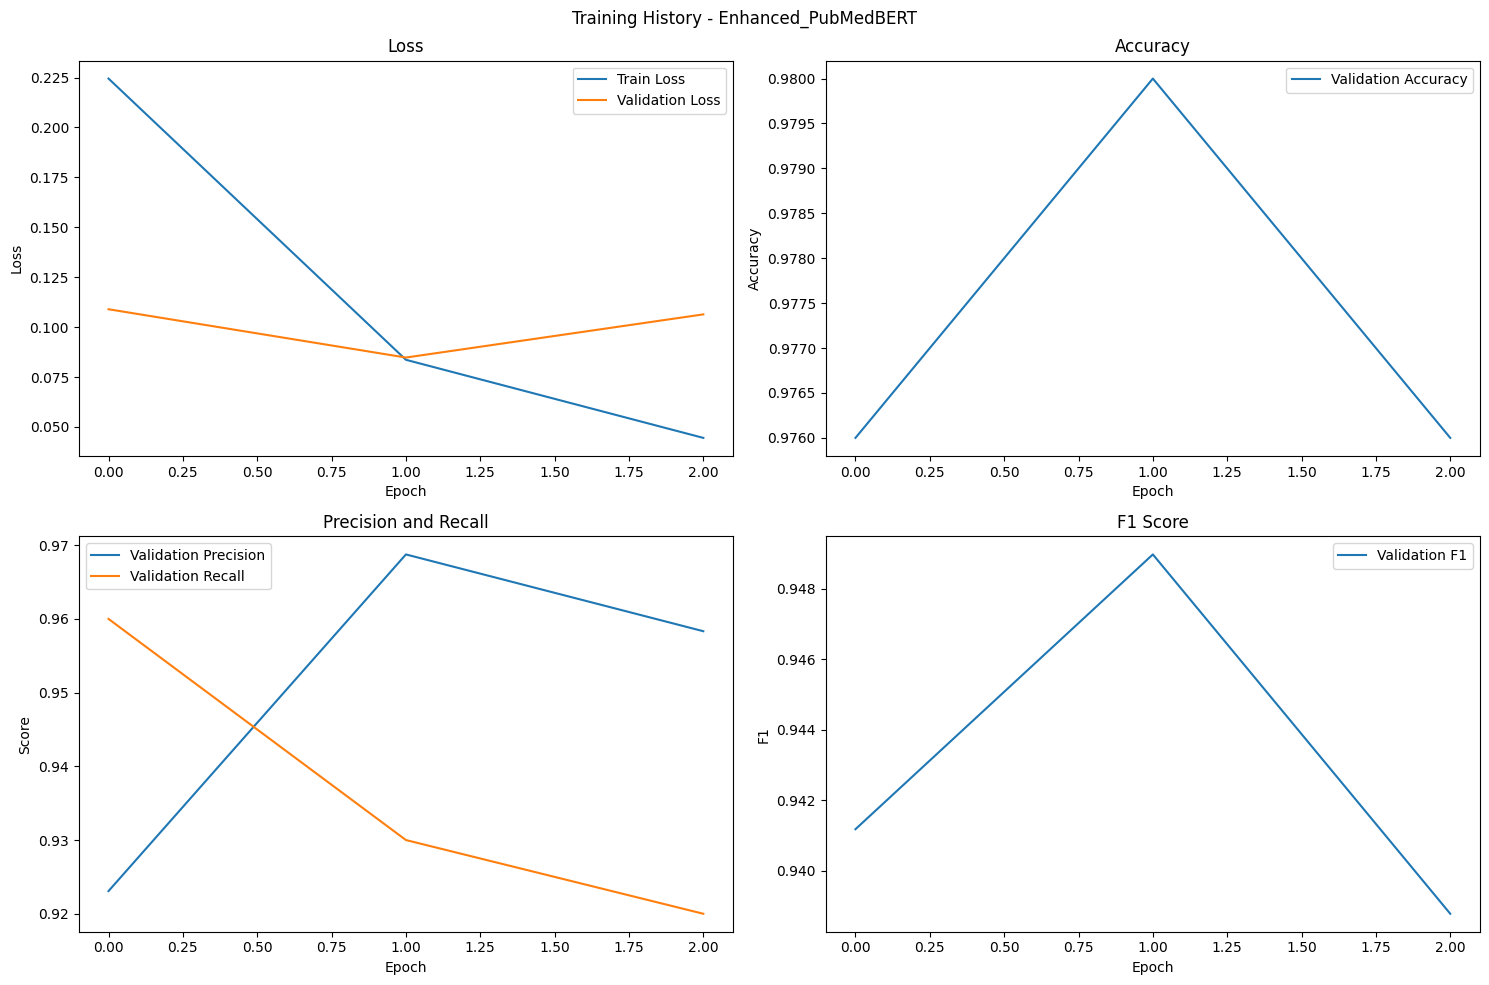

In [ ]:
# Train and evaluate the enhanced model
print("\n=== Enhanced Model (HierarchicalPubMedBERT) ===")

# Model name for PubMedBERT
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"

# Prepare data for enhanced model
train_dataloader_enh, val_dataloader_enh, test_dataloader, train_df, val_df, test_df = prepare_data(
    df, model_name, augment=True, sample_size=sample_size
)

# Initialize enhanced model
enhanced_model = HierarchicalPubMedBERT(model_name)
enhanced_model.to(device)

# Train enhanced model
enhanced_model, enhanced_history = train_model(
    enhanced_model,
    train_dataloader_enh,
    val_dataloader_enh,
    num_epochs=3,
    learning_rate=2e-5,
    use_focal_loss=True
)

# Evaluate enhanced model on test set
_, enhanced_metrics = evaluate_model(enhanced_model, test_dataloader)

# Get enhanced model predictions
enhanced_preds, enhanced_probs, test_labels = predict_proba(enhanced_model, test_dataloader)

# Create enhanced results DataFrame
enhanced_results_df = test_df.copy()
enhanced_results_df['true_label'] = test_labels
enhanced_results_df['predicted_label'] = enhanced_preds
enhanced_results_df['probability'] = enhanced_probs[:, 1]
enhanced_results_df['correct'] = enhanced_results_df['true_label'] == enhanced_results_df['predicted_label']

# Perform error analysis on enhanced model
print("\n=== Enhanced Model Error Analysis ===")
analyze_errors(enhanced_results_df, model_name="Enhanced Model")

# Plot training history
plot_training_history(enhanced_history, "Enhanced_PubMedBERT")


=== Vanilla PubMedBERT Model ===
Sampled dataset size: 5000
Sampled RCT distribution: is_rct
0    4001
1     999
Name: count, dtype: int64
Train set size: 4000
Validation set size: 500
Test set size: 500


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2431
Val Loss: 0.0995
Val Accuracy: 0.9740
Val Precision: 0.9579
Val Recall: 0.9100
Val F1: 0.9333
--------------------------------------------------
Epoch 2/3


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1100
Val Loss: 0.0984
Val Accuracy: 0.9720
Val Precision: 0.9300
Val Recall: 0.9300
Val F1: 0.9300
--------------------------------------------------
Epoch 3/3


Training:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0763
Val Loss: 0.1161
Val Accuracy: 0.9680
Val Precision: 0.9200
Val Recall: 0.9200
Val F1: 0.9200
--------------------------------------------------


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Predicting:   0%|          | 0/16 [00:00<?, ?it/s]

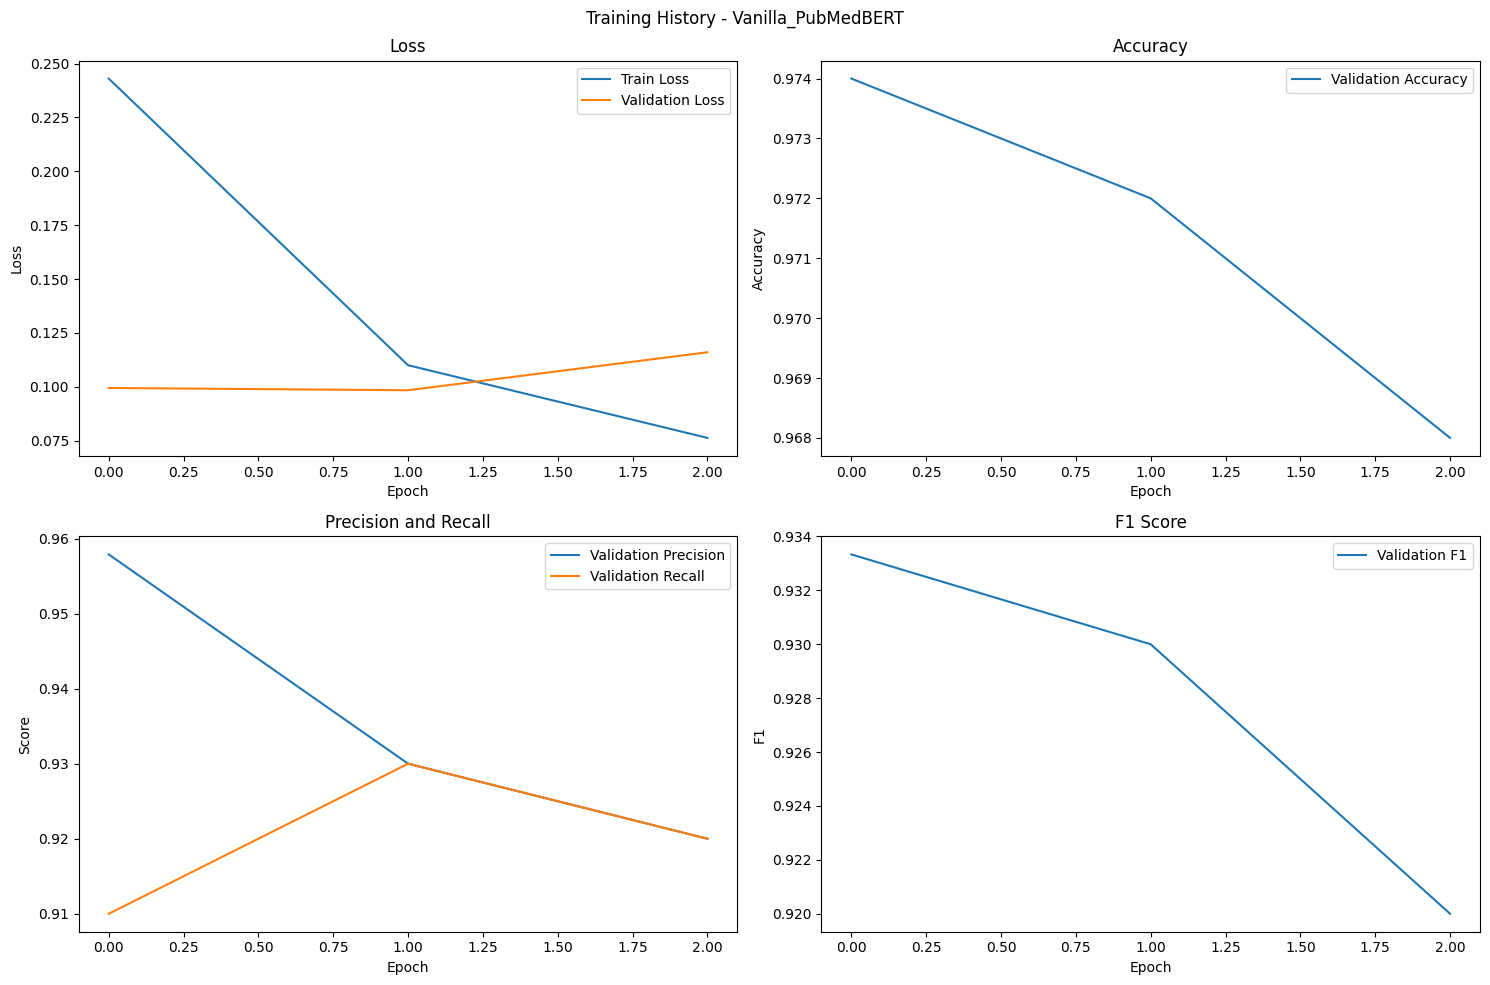

In [ ]:
# Train and evaluate vanilla PubMedBERT
print("\n=== Vanilla PubMedBERT Model ===")

# Prepare data for vanilla model
train_dataloader_van, val_dataloader_van, test_dataloader, _, _, _ = prepare_data(
    df, model_name, augment=False, sample_size=sample_size
)

# Initialize vanilla model
vanilla_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
).to(device)

# Train vanilla model
vanilla_model, vanilla_history = train_model(
    vanilla_model,
    train_dataloader_van,
    val_dataloader_van,
    num_epochs=3,
    learning_rate=2e-5,
    use_focal_loss=False
)

# Evaluate vanilla model
_, vanilla_metrics = evaluate_model(vanilla_model, test_dataloader)

# Get vanilla model predictions
vanilla_preds, vanilla_probs, _ = predict_proba(vanilla_model, test_dataloader)

# Create vanilla results DataFrame
vanilla_results_df = test_df.copy()
vanilla_results_df['true_label'] = test_labels
vanilla_results_df['predicted_label'] = vanilla_preds
vanilla_results_df['probability'] = vanilla_probs[:, 1]
vanilla_results_df['correct'] = vanilla_results_df['true_label'] == vanilla_results_df['predicted_label']

# Plot training history
plot_training_history(vanilla_history, "Vanilla_PubMedBERT")

In [ ]:
# Compare results
print("\n=== Model Comparison ===")
print(f"Enhanced Model Metrics:")
print(f"Accuracy: {enhanced_metrics['accuracy']:.4f}")
print(f"Precision: {enhanced_metrics['precision']:.4f}")
print(f"Recall: {enhanced_metrics['recall']:.4f}")
print(f"F1: {enhanced_metrics['f1']:.4f}")

print(f"\nVanilla PubMedBERT Metrics:")
print(f"Accuracy: {vanilla_metrics['accuracy']:.4f}")
print(f"Precision: {vanilla_metrics['precision']:.4f}")
print(f"Recall: {vanilla_metrics['recall']:.4f}")
print(f"F1: {vanilla_metrics['f1']:.4f}")

# Print difference
print(f"\nDifference (Enhanced - Vanilla):")
print(f"Accuracy: {(enhanced_metrics['accuracy'] - vanilla_metrics['accuracy'])*100:.2f}%")
print(f"Precision: {(enhanced_metrics['precision'] - vanilla_metrics['precision'])*100:.2f}%")
print(f"Recall: {(enhanced_metrics['recall'] - vanilla_metrics['recall'])*100:.2f}%")
print(f"F1: {(enhanced_metrics['f1'] - vanilla_metrics['f1'])*100:.2f}%")


=== Model Comparison ===
Enhanced Model Metrics:
Accuracy: 0.9540
Precision: 0.8969
Recall: 0.8700
F1: 0.8832

Vanilla PubMedBERT Metrics:
Accuracy: 0.9500
Precision: 0.8641
Recall: 0.8900
F1: 0.8768

Difference (Enhanced - Vanilla):
Accuracy: 0.40%
Precision: 3.28%
Recall: -2.00%
F1: 0.64%


In [ ]:
# Compare with Bat4RCT baselines
comparison_dict = {
    'Heuristic': {'accuracy': 91.78, 'precision': 83.70, 'recall': 73.14, 'f1': 78.06},
    'SVM': {'accuracy': 95.33, 'precision': 91.93, 'recall': 84.04, 'f1': 87.81},
    'CNN': {'accuracy': 95.29, 'precision': 92.16, 'recall': 83.55, 'f1': 87.64},
    'BERT': {'accuracy': 96.27, 'precision': 91.97, 'recall': 89.11, 'f1': 90.52},
    'BioBERT': {'accuracy': 96.37, 'precision': 91.52, 'recall': 90.18, 'f1': 90.85},
    'Enhanced Model': {
        'accuracy': enhanced_metrics['accuracy'] * 100,
        'precision': enhanced_metrics['precision'] * 100,
        'recall': enhanced_metrics['recall'] * 100,
        'f1': enhanced_metrics['f1'] * 100
    },
    'Vanilla PubMedBERT': {
        'accuracy': vanilla_metrics['accuracy'] * 100,
        'precision': vanilla_metrics['precision'] * 100,
        'recall': vanilla_metrics['recall'] * 100,
        'f1': vanilla_metrics['f1'] * 100
    }
}

# Create comparison DataFrame
comparison_df = pd.DataFrame.from_dict(comparison_dict, orient='index')
print("\nComparison with Bat4RCT baselines:")
print(comparison_df)

# Model names for additional visualizations
model_names = ['Enhanced Model', 'Vanilla PubMedBERT']


Comparison with Bat4RCT baselines:
                    accuracy  precision  recall         f1
Heuristic              91.78  83.700000   73.14  78.060000
SVM                    95.33  91.930000   84.04  87.810000
CNN                    95.29  92.160000   83.55  87.640000
BERT                   96.27  91.970000   89.11  90.520000
BioBERT                96.37  91.520000   90.18  90.850000
Enhanced Model         95.40  89.690722   87.00  88.324873
Vanilla PubMedBERT     95.00  86.407767   89.00  87.684729


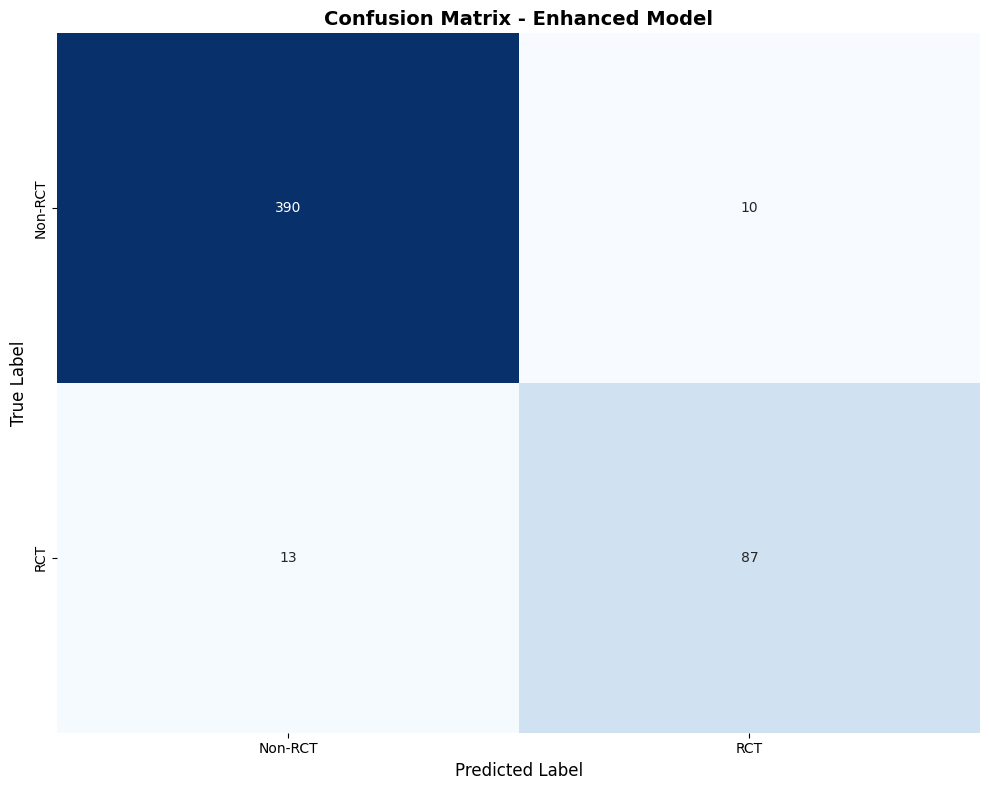

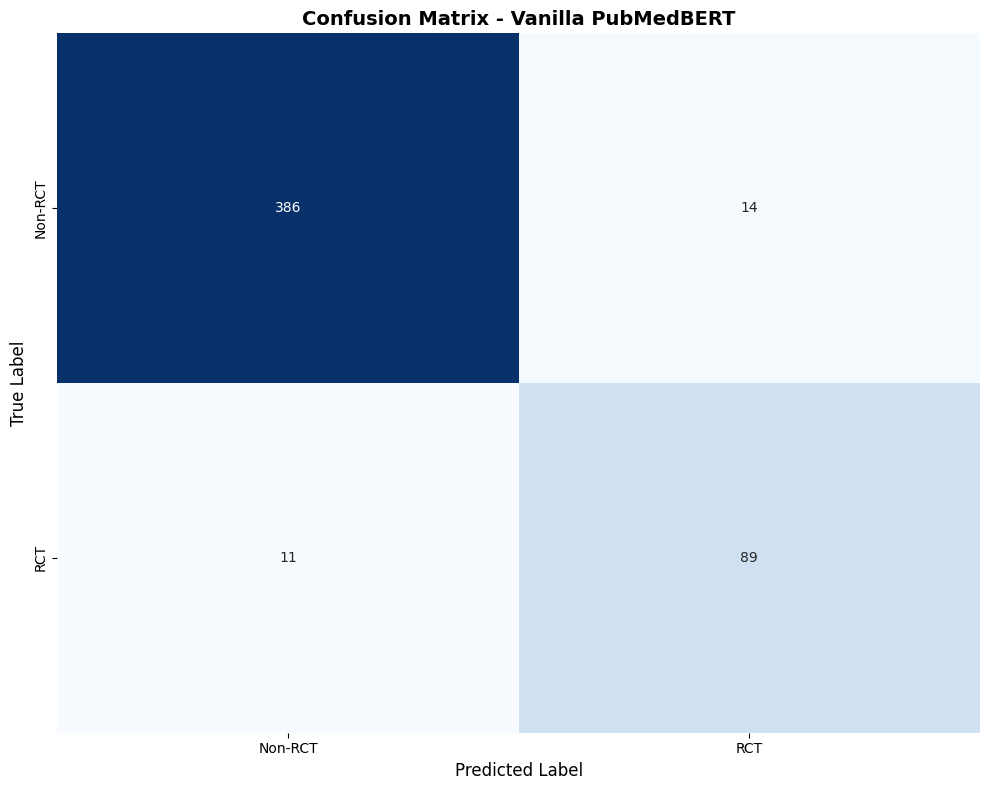

In [ ]:
# Plot confusion matrices
plot_confusion_matrix(test_labels, enhanced_preds, model_names[0])
plot_confusion_matrix(test_labels, vanilla_preds, model_names[1])

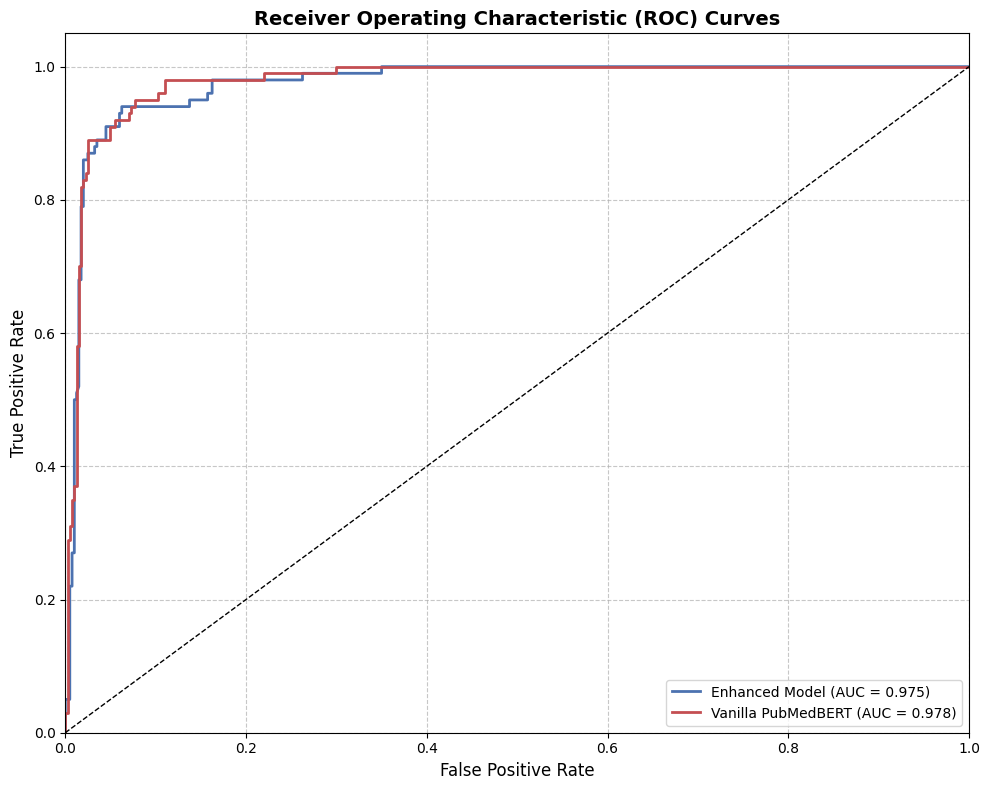

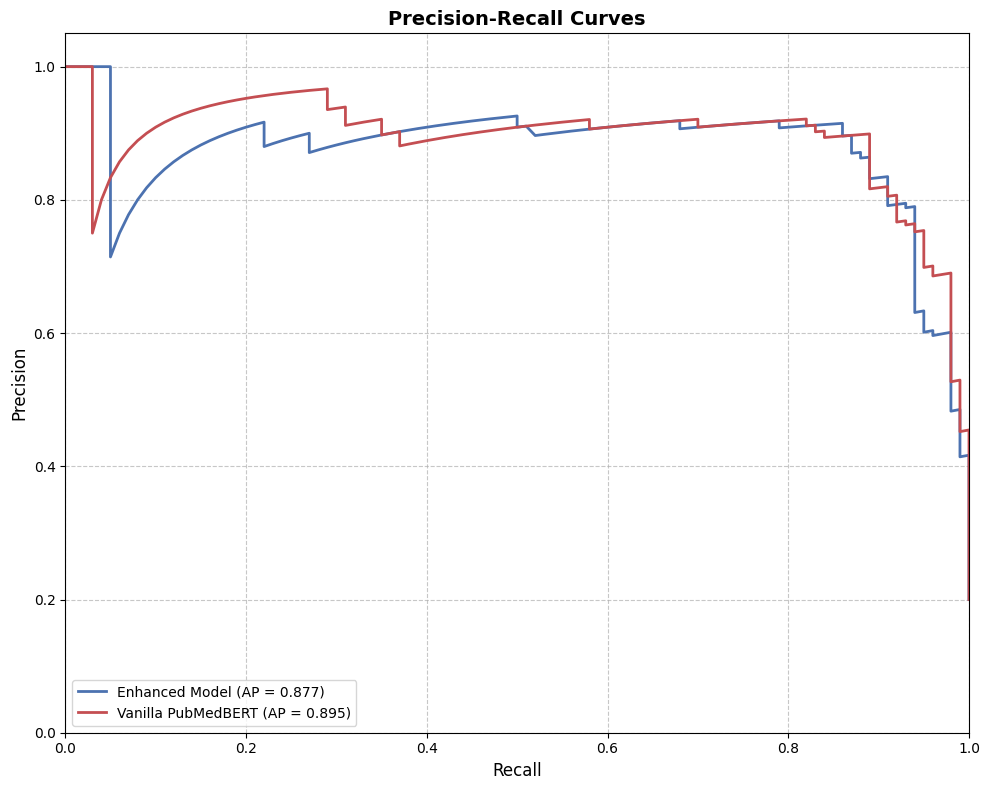

In [ ]:
# Plot ROC and Precision-Recall curves
plot_roc_curve([test_labels, test_labels], [enhanced_probs, vanilla_probs], model_names)
plot_precision_recall_curve([test_labels, test_labels], [enhanced_probs, vanilla_probs], model_names)

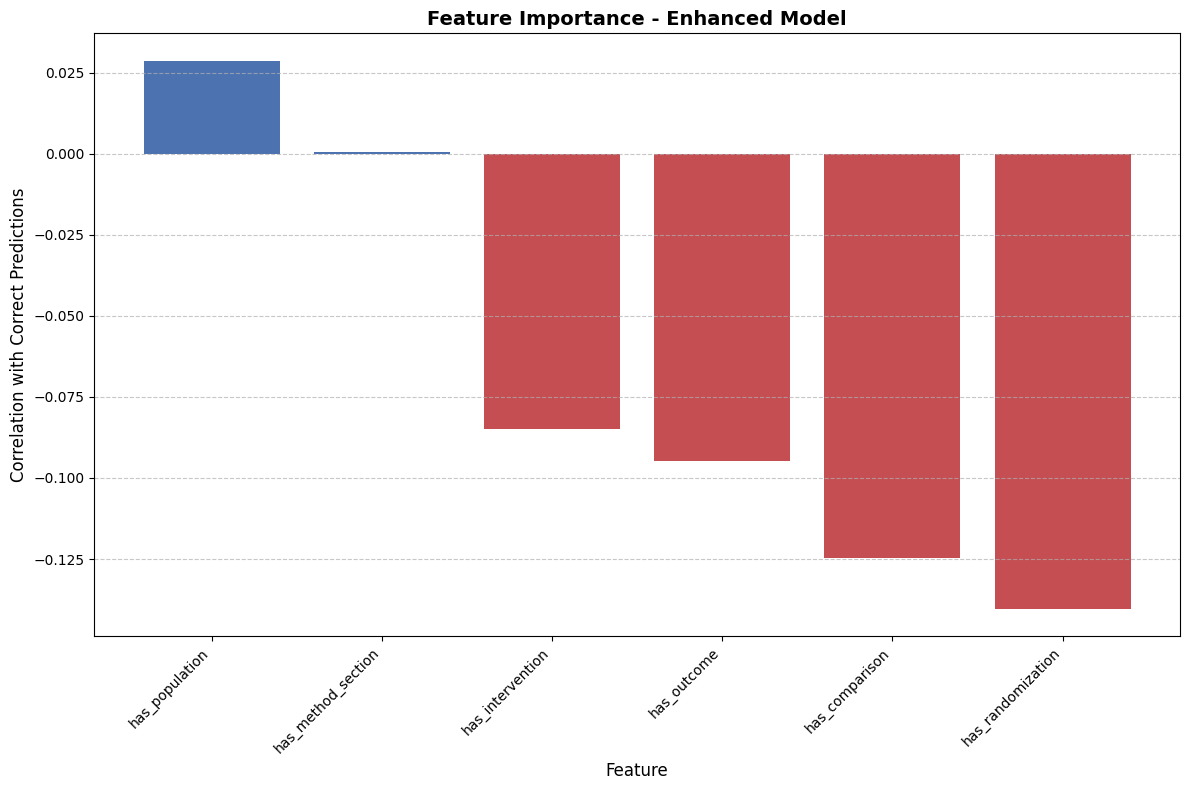

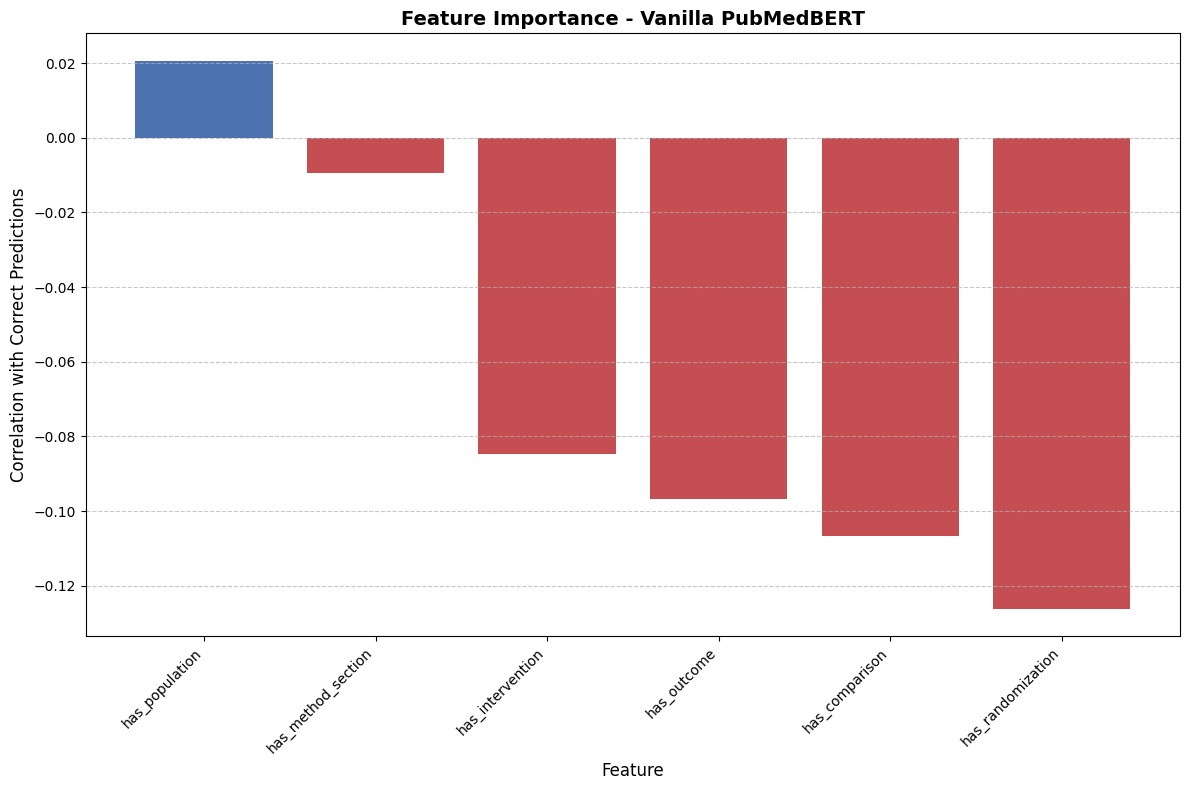

In [ ]:
# Feature analysis
feature_cols = ['has_population', 'has_intervention', 'has_comparison', 'has_outcome',
              'has_randomization', 'has_method_section']

# Plot feature importance
plot_feature_importance(enhanced_results_df, feature_cols, model_names[0])
plot_feature_importance(vanilla_results_df, feature_cols, model_names[1])

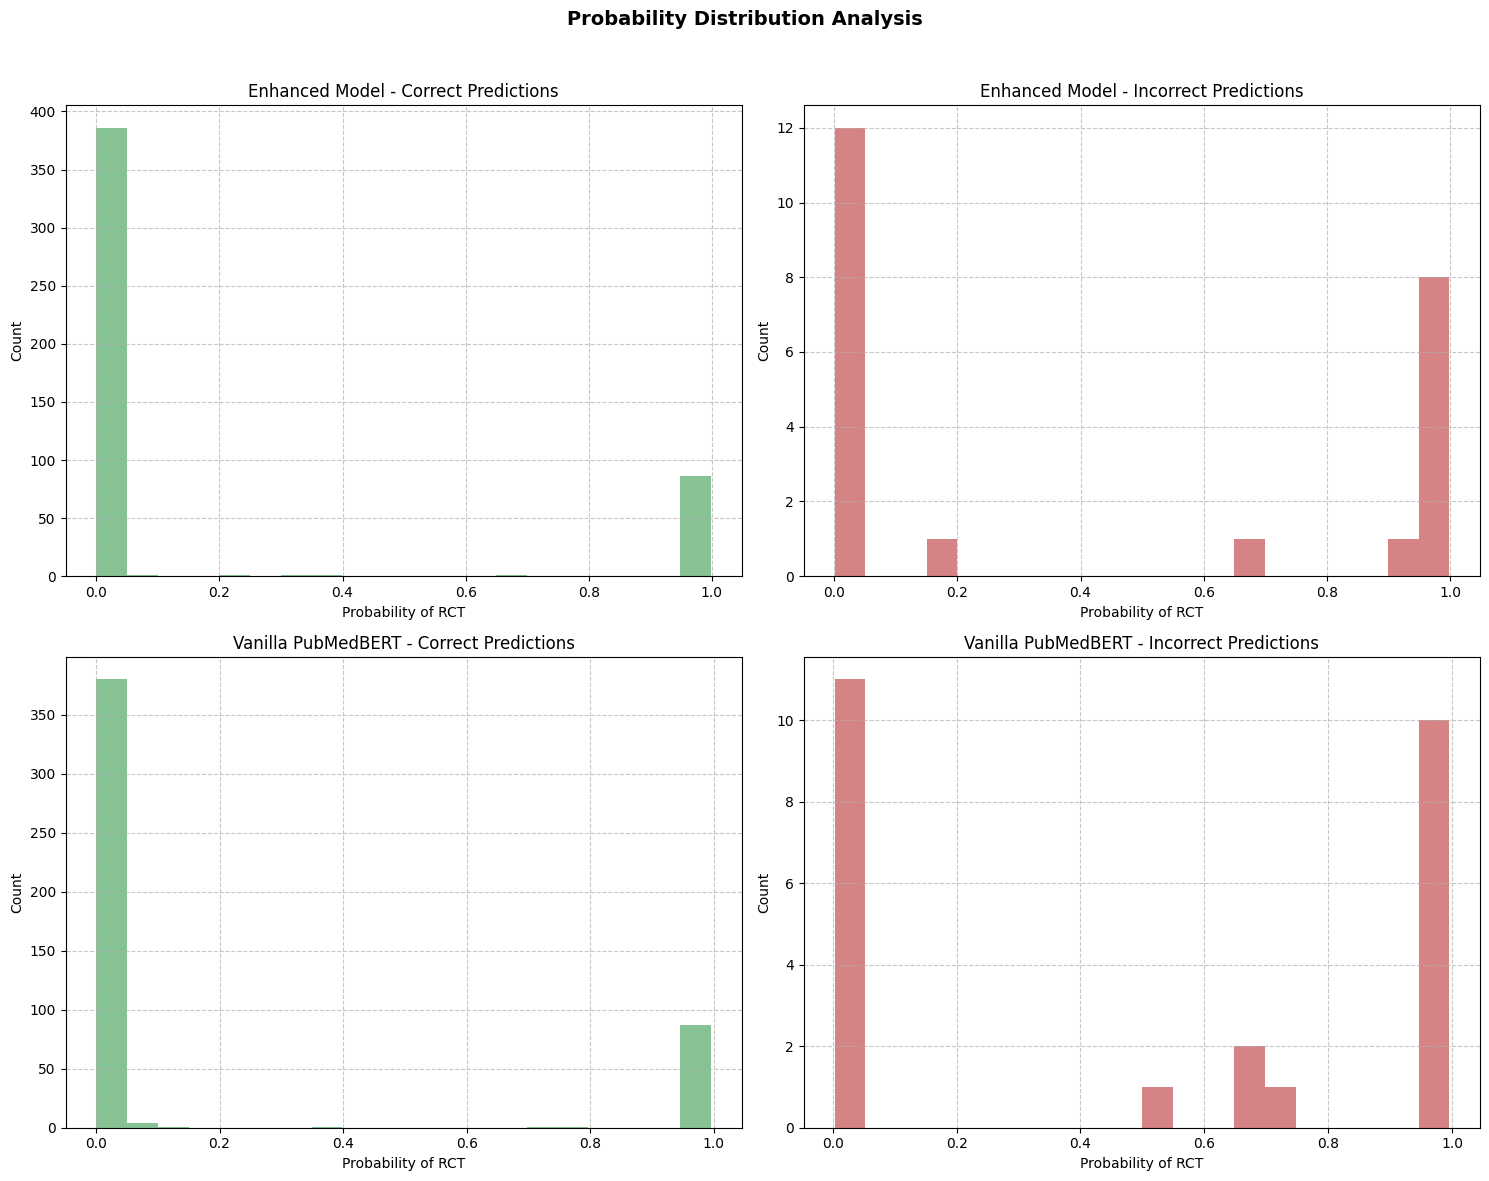

In [ ]:
# Plot probability distributions
plot_probability_distribution(enhanced_results_df, vanilla_results_df, model_names)

<Figure size 1400x1000 with 0 Axes>

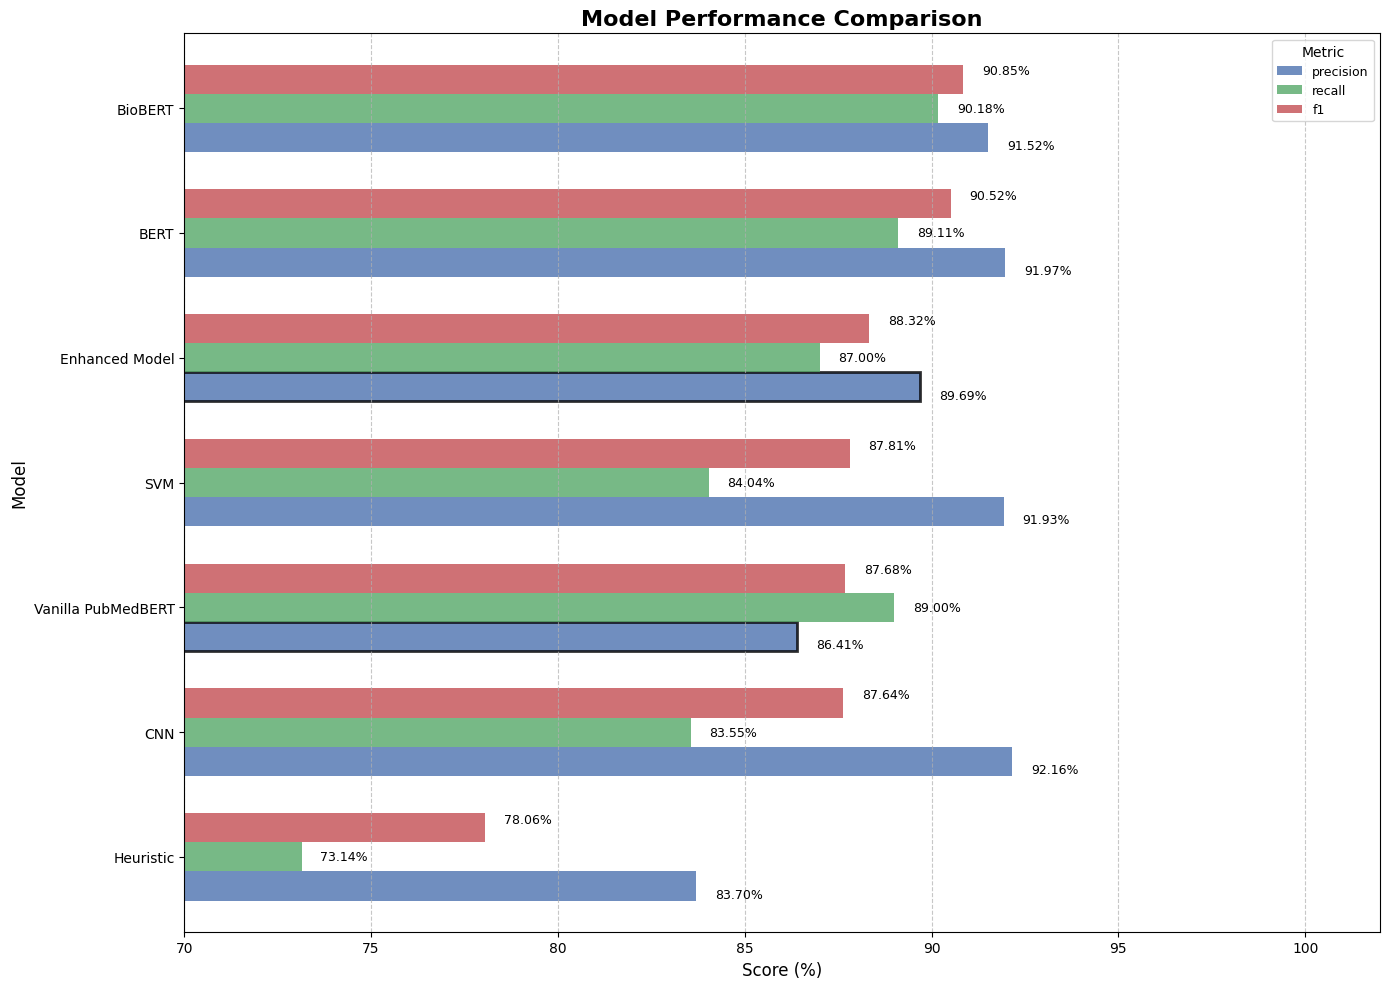

In [ ]:
# Plot enhanced baseline comparison
plot_baseline_comparison(comparison_df)